# GW forward model for ILI (frequency domain)
### Author:
  - [@CompiledAtBirth](https://github.com/CompiledAtBirth) (Nicolas Chartier)


## Summary

The goal is to try out some strategies to implement the Implicit Likelihod Inference (ILI) forward model of Gravitational Wave strain.

In [2]:
!python --version
!pip install pycbc --quiet

Python 3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Get

In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# PYCBC and LAL imports

from pycbc.detector import Detector, get_available_detectors
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform, get_fd_waveform
from pycbc.waveform import generator, get_fd_waveform_from_td, get_td_waveform_from_fd
from pycbc.waveform.generator import FDomainDetFrameGenerator
from pycbc.psd import from_numpy_arrays, from_string, from_txt, welch,interpolate
#from pycbc.noise.gaussian import noise_from_psd, frequency_noise_from_psd
import pycbc.noise as pynoise
from pycbc.types import FrequencySeries, TimeSeries, complex_same_precision_as, real_same_precision_as, Array
from pycbc.filter import matchedfilter, sigmasq, make_frequency_series, highpass_fir, lowpass_fir, get_cutoff_indices
from pycbc.catalog import Merger
from urllib.request import urlretrieve
from pycbc.frame import read_frame
from pycbc.waveform.utils import apply_fd_time_shift, taper_timeseries, \
                                 ceilpow2
import lal as _lal # _lal.LIGOTimeGPS

# If windowing (optional)
from scipy.signal import tukey

/usr/local/lib/python3.10/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


## Functions for forward model


In [4]:
def time_shift_fd(freq_series, t_shift):
  '''
  The function  apply_fd_time_shift may be deprecated as in the waveform.generator code w/ waveform.utils the epoch shift is applied twice?
  I cook my own function
  '''
  dt = float(t_shift - freq_series.start_time)
  freqs = freq_series.sample_frequencies.numpy()
  shift_arr =  np.array(np.exp(-2j*np.pi*(dt)*freqs), dtype=complex_same_precision_as(freq_series))

  return FrequencySeries(shift_arr*freq_series.data, delta_f = freq_series.delta_f)
def waveform_polarizations(approximant, params_dict):

    if "delta_f" in params_dict:
        #hp, hc = get_td_waveform_from_fd(approximant=approximant, **params_dict)
        hp, hc = get_fd_waveform(approximant=approximant, **params_dict)
    else:
        raise ValueError("You must have either delta_t or delta_f in the dictionary")

    return hp, hc

def detector_frame_strain(hp, hc, detectors, det_params, verbose = False):

  '''
  detectors = List[str], for detector names
  domains = [bool_time, bool_freq],determines if we use data in time domain, frequency domain or both
  epoch : {float, lal.LIGOTimeGPS
          The epoch start time to set the waveform to. A time shift = tc - epoch is
          applied to waveforms before returning.
  tc: The GPS time of coalescence (should be geocentric time)
  '''

  h = {}
  detectors = {det: Detector(det) for det in detectors}
  hp.start_time = hc.start_time = det_params["start_time"]

  if isinstance(hp, FrequencySeries) and isinstance(hc, FrequencySeries):

      for detname, det in detectors.items():
        # apply detector response function
        fp, fc = det.antenna_pattern(det_params['ra'], det_params['dec'], det_params['polarization'],det_params['tc'])
        h_det = fp*hp + fc*hc

        # apply the time shift
        dt = det_params["tc"]+ det.time_delay_from_earth_center(det_params['ra'],det_params['dec'],det_params['tc'])
        if verbose:
          print("Time shift will be %.5f s"%(dt - h_det.start_time))
        h_det = time_shift_fd(h_det, dt) # my function, I understand what is happening
        #h_det = apply_fd_time_shift(h_det,dt)
        h[detname] = h_det

  else:
      raise ValueError("You must provide two TimeSeries or two FrequencySeries instance")

  return h

def inject_into_noise_fd(projected_signal, my_psd, fmin, fmax, tol = 1e-7):
  '''
  my_psd: FrequencySeries instance
  noise_timeseries: a TimeSeries instance corresponding to a random noise draw
  '''

  df = projected_signal.delta_f
  if abs(my_psd.delta_f - df) > tol:
    raise Exception(f"Signal dd = {projected_signal.delta_f} does not "f"match psd df {my_psd.delta_f}")

  N = (len(projected_signal)-1) * 2
  k_min, k_max = get_cutoff_indices(fmin, fmax, df,N )
  s = projected_signal.data[k_min:k_max]
  f = projected_signal.sample_frequencies[k_min:k_max]

  noise = np.random.randn(len(s)) + 1j * np.random.randn(len(s))
  noise *= np.sqrt(my_psd.data[k_min:k_max])* 1./np.sqrt(4.0*df)

  return f,s,noise

## Parameters for example

Strategy, we are going to put tc somewhere in the middle of the waveform (where the prior "center" will be at inference stage)

In [5]:
# Time and duration parameters
tc = 1126259462.420 # time of coalescence in seconds
noise_duration = 8. # in seconds

# We place the coalescence time here right at the midlle of the waveform in time domain.
my_epoch = tc - noise_duration/2. # starting time of the waveform

#approximant = "SEOBNRv4T" # time-domain
approximant = "IMRPhenomPv2" # frequency domain

# Parametrization for masses
q = 1.15625
M = 69. # in solar masses

mass1 = (q * M)/(q + 1.0)
mass2 = M/(q + 1.0)
ra = 2.2
dec = -1.25
inclination = 2.5
coa_phase = 1.5 # in rad
polarization = 1.75
distance = 400. # in MPc/h
f_ref = 15
f_lower = 15

cbc_params = {"distance": distance,
             "mass1": mass1,
             "mass2": mass2,
              "spin1z": 0.,
              "spin2z": 0.,
             "inclination": inclination, # inclination angle
              "f_lower": f_lower,
              "f_ref": f_ref,
             "coa_phase": coa_phase}

det_params = {"ra": ra,
              "dec": dec,
              "polarization":polarization,
              "start_time":my_epoch,
              "tc":tc
             }

## Generate waveform in radiation frame

In [6]:
srate = 2048.
delta_t = 1./srate

td = False
if td:
  cbc_params["delta_t"] = delta_t
else:
  cbc_params["delta_f"] = 1./noise_duration

start = time.time()
hp, hc = waveform_polarizations(approximant, cbc_params)
end = time.time()
print("%.2f seconds for computation" %(end - start))
print("Waveform delta_f is %.6f"%hp.delta_f)
print("Waveform delta_t is %.6f"%hp.delta_t)
print(len(hp))

0.08 seconds for computation
Waveform delta_f is 0.125000
Waveform delta_t is 0.000488
8193


# Frequency domain cells only

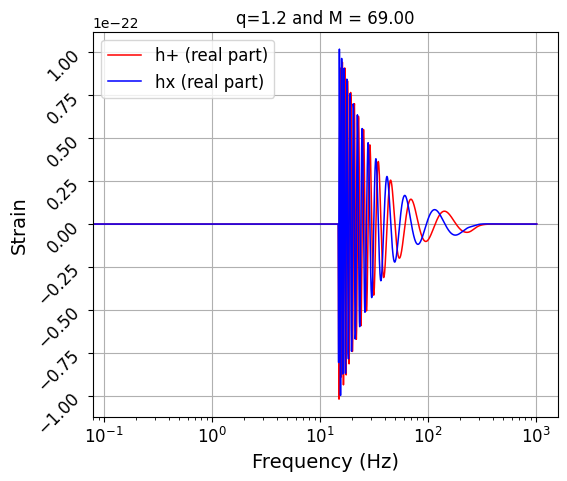

In [7]:
# Example Figure
plt.figure(figsize =(6,5))
plt.plot(hp.sample_frequencies, hp.data.real, label = "h+ (real part)", color = "red", linewidth = 1.1)
plt.plot(hc.sample_frequencies, hc.data.real, label = "hx (real part)", color = "blue", linewidth = 1.1)
plt.legend(fontsize = 12, loc = "upper left")
plt.xlabel("Frequency (Hz)", fontsize = 14)
plt.xscale("log")
plt.ylabel("Strain", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12, rotation = 45)
plt.title("q=%.1f and M = %.2f"%(q,M), loc = "center")
plt.grid()

Time shift will be 4.01574 s
Time shift will be 4.00882 s


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


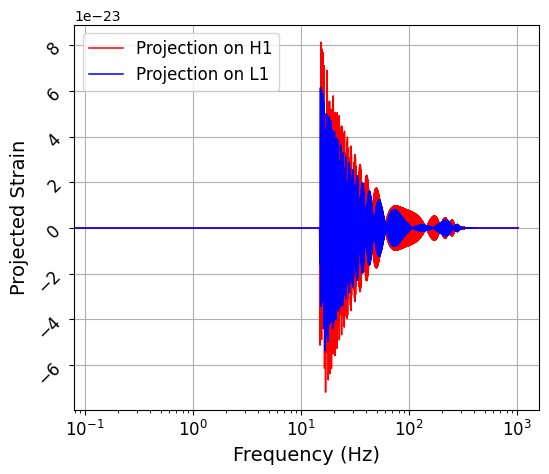

In [8]:
my_detectors = ["H1", "L1"]

# Some tests to understand detector class
detector = Detector(my_detectors[0])
type(detector.response)

# Project onto detectors
h = detector_frame_strain(hp, hc, my_detectors, det_params, verbose = True)
%matplotlib inline

# Plot the strains for illustration
ht1 = h[my_detectors[0]]
ht2 = h[my_detectors[1]]
plt.figure(figsize =(6,5))
plt.plot(ht1.sample_frequencies, ht1.data, label = "Projection on %s"%my_detectors[0], color = "red", linewidth = 1.1)
plt.plot(ht2.sample_frequencies, ht2.data, label = "Projection on %s"%my_detectors[1], color = "blue", linewidth = 1.1)
plt.legend(fontsize = 12, loc = "upper left")
plt.xlabel("Frequency (Hz)", fontsize = 14)
plt.xscale("log")
plt.ylabel("Projected Strain", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12, rotation = 45)
plt.grid()

In [9]:
# Generate psd with right delta_f
# For analytical Power Spectral Density
psd_str = "aLIGOZeroDetHighPower"
f_low_psd = 15. # in Hz
Nfft = len(h[my_detectors[0]])
psd_det = from_string(psd_str, Nfft, delta_f = 1./noise_duration, low_freq_cutoff = f_low_psd)

ht1 = h[my_detectors[0]]
ht2 = h[my_detectors[1]]

# Injection in freq. domain
fmin = 20. # in Hz, higher than f_low_psd and lower freq. of approximant computation
Nt = (Nfft -1)*2
# Use delta_f = Fs/Nt to get fmax (Nyquist-Shannon)
fmax = 0.5 * ht1.delta_f*Nt

f1,s1,n1 = inject_into_noise_fd(ht1, psd_det, fmin, fmax, tol = 1e-7)
f2,s2,n2 = inject_into_noise_fd(ht2, psd_det, fmin, fmax, tol = 1e-7)

In [11]:
print("Size of summary in one detector is %i"%len(s1))

Size of summary in one detector is 8032


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


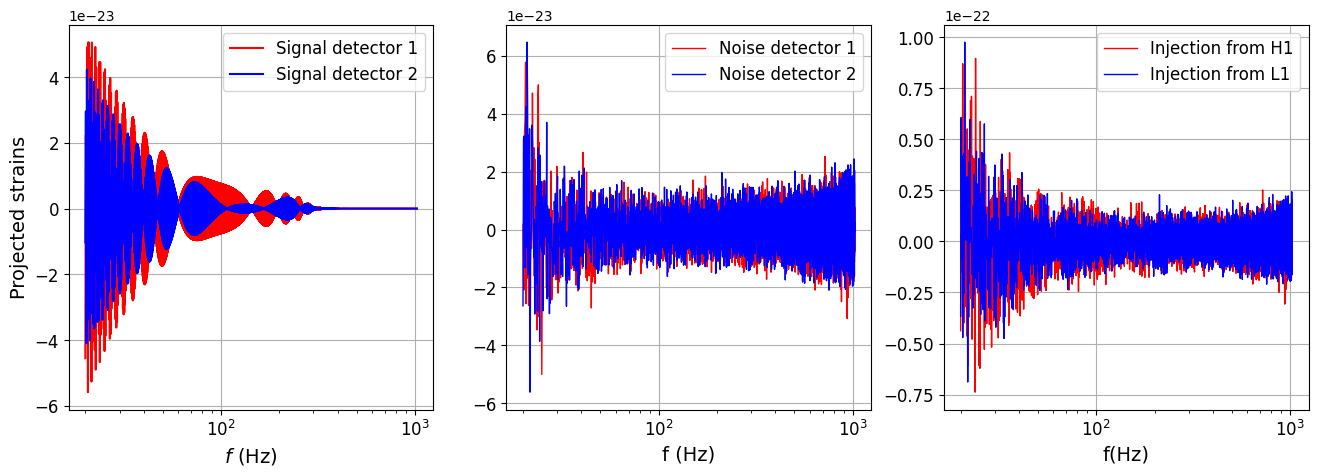

In [12]:
fig,ax = plt.subplots(1,3,figsize=(16,5))
ax[0].plot(f1, s1, color = "red", label = "Signal detector 1")
ax[0].plot(f2, s2, color = "blue", label = "Signal detector 2")
ax[0].set_xscale('log')
ax[0].grid()
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel("$f$ (Hz)", fontsize = 14)
ax[0].set_ylabel("Projected strains", fontsize = 14)
ax[0].legend(fontsize = 12, loc = "best")

ax[1].plot(f1,n1, color = "red", label = "Noise detector 1", linewidth = 1.0)
ax[1].plot(f2,n2, color = "blue", label = "Noise detector 2", linewidth = 1.0)
ax[1].set_xscale('log')
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel("f (Hz)", fontsize = 14)
ax[1].legend(fontsize = 12, loc = "best")

ax[2].plot(f1, n1+s1, color = "red", label = "Injection from %s"%my_detectors[0], linewidth = 1.0)
ax[2].plot(f2, n2+s2, color = "blue", label = "Injection from %s"%my_detectors[1], linewidth = 1.0)
ax[2].set_xscale('log')
ax[2].grid()
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].set_xlabel("f(Hz)", fontsize = 14)
ax[2].legend(fontsize = 12, loc = "best")